In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer

# Define the list of gun-related words
gun_related_words = ['gun', '2nd amendment', 'second amendment', 'ar-15', 'assault rifle', 'pistols', 'shooting', 'mass shooting', 'school shooting', 'march for our lives']

# Function to check if any word from the list is present in the text
def contains_word(text, word_list):
    if pd.isnull(text):  # Check if the text is NaN
        return 0
    for word in word_list:
        if word.lower() in text.lower():  # Case insensitive match
            return 1
    return 0

# Load the CSV file into a pandas DataFrame
file_path = 'jack_handcode.csv' 
data = pd.read_csv(file_path)

# Create the new column 'gunsentiment'
data['gunsentiment'] = data['message'].apply(lambda x: contains_word(x, gun_related_words))

# Calculate number of documents
num_documents = len(data)

# Calculate average document length (in terms of words)
data['word_count'] = data['message'].apply(lambda x: len(str(x).split()))
average_doc_length = data['word_count'].mean()

# Distribution of document lengths
doc_length_distribution = data['word_count'].describe()

# Balance of the dataset
label_distribution = data['gunsentiment'].value_counts(normalize=True)

print("Number of Documents:", num_documents)
print("Average Document Length (in words):", average_doc_length)
print("\nDistribution of Document Lengths:")
print(doc_length_distribution)
print("\nBalance of the Dataset:")
print(label_distribution)

# Filter documents related to gun legislation
gun_legislation_messages = data[data['dummy_label'] == 1]['message'].dropna().tolist()

# Custom function for text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert ENGLISH_STOP_WORDS to a list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Create TF-IDF vectorizer with text cleaning and stop words removal
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(gun_legislation_messages)

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across documents
word_scores = tfidf_matrix.sum(axis=0)

# Sort the words by TF-IDF score in descending order
sorted_word_indices = word_scores.argsort()[0, ::-1]

# Display the top words associated with gun legislation
print("\nTop words associated with gun legislation:")
for i in range(10):  # Display top 10 words
    word_index = sorted_word_indices[0, i]
    word = tfidf_feature_names[word_index]
    score = word_scores[0, word_index]
    print(f"{word}: {score}")

# Create CountVectorizer with text cleaning and stop words removal
count_vectorizer = CountVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
X = count_vectorizer.fit_transform(gun_legislation_messages)

# Perform LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)  # Change n_components as needed
lda.fit(X)

# Display the top words for each topic
feature_names = count_vectorizer.get_feature_names_out()
print("\nTop words for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_indices = topic.argsort()[:-11:-1]  # Display top 10 words
    top_words = [feature_names[i] for i in top_words_indices]
    print(", ".join(top_words))

# Perform sentiment analysis for each message
nltk.download('vader_lexicon')  # Download the lexicon required for sentiment analysis
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each message
sentiments = []
for message in data['message']:
    if pd.notnull(message):
        message = str(message)  # Ensure message is a string
        sentiment_score = sid.polarity_scores(message)
        # Classify sentiment based on compound score
        if sentiment_score['compound'] >= 0.05:
            sentiment = 'Positive'
        elif sentiment_score['compound'] <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
    else:
        sentiment = 'Neutral'
    sentiments.append(sentiment)

# Add the sentiment labels to the DataFrame
data['sentiment'] = sentiments

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(data[['message', 'sentiment']])

Number of Documents: 4000
Average Document Length (in words): 60.8745

Distribution of Document Lengths:
count    4000.000000
mean       60.874500
std       122.760754
min         2.000000
25%        23.000000
50%        37.000000
75%        58.000000
max      1833.000000
Name: word_count, dtype: float64

Balance of the Dataset:
gunsentiment
0    0.74925
1    0.25075
Name: proportion, dtype: float64

Top words associated with gun legislation:
gun: 53.92455842013452
violence: 28.608159802524977
congress: 23.20246356007677
guns: 22.65954332561255
safety: 20.57712785740269
help: 20.288424809400144
march: 20.21774081321494
pp: 20.082281473142263
nra: 19.682073619830096
support: 19.02588664964555

Top words for each topic:
Topic 0:
gun, violence, congress, school, safety, petition, make, guns, pp, sign
Topic 1:
pp, gun, help, just, trump, donate, right, people, time, im


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arlu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Sentiment analysis results:
                                                message sentiment
0     <p>We will no longer sit idly by while Paul Ry...  Positive
1     <p>What happened in <a class="_58cn"><span cla...  Negative
2     <p>After so many out-of-state billionaires hav...  Positive
3     <p>3D printing is the latest battleground in t...  Negative
4     <p>BREAKING: Congress will vote on legislation...  Negative
...                                                 ...       ...
3995  <p>Kavanaugh is the least popular nominee to t...  Positive
3996  <p>Progressives of all shades of blue need to ...   Neutral
3997  <p>My district has been recognized by FiveThir...  Positive
3998  <span class="q_axnnj3hgw">Donate now to help c...  Positive
3999  <p>“When I eat meals at school, it makes me fa...  Positive

[4000 rows x 2 columns]


In [ ]:
predictions = pd.read_csv('Data/predictions.xls')
data_inp = pd.read_csv('Data/fbpac-ads-en-US.csv')
print(predictions.columns)

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer


data = pd.merge(predictions, data_inp, on='id', how='inner')

# Ensure 'created_at' is datetime and convert to UTC if not already
data['created_at'] = pd.to_datetime(data['created_at'], utc=True, errors='coerce')  # 'coerce' handles any parsing errors gracefully

# Define the date ranges for March for Our Lives and Parkland shooting
march_for_our_lives_date = pd.to_datetime('2018-03-24', utc=True)
parkland_shooting_date = pd.to_datetime('2018-02-14', utc=True)

# Define 6 months timedelta
six_months = pd.Timedelta(days=6*30)

# Filter messages related to March for Our Lives
before_march = data[(data['created_at'] > (march_for_our_lives_date - six_months)) & (data['created_at'] <= march_for_our_lives_date)]
after_march = data[(data['created_at'] > march_for_our_lives_date) & (data['created_at'] <= (march_for_our_lives_date + six_months))]

# Filter messages related to Parkland shooting
before_parkland = data[(data['created_at'] > (parkland_shooting_date - six_months)) & (data['created_at'] <= parkland_shooting_date)]
after_parkland = data[(data['created_at'] > parkland_shooting_date) & (data['created_at'] <= (parkland_shooting_date + six_months))]

# Combine all messages related to gun legislation during these periods
gun_legislation_messages = pd.concat([before_march, after_march, before_parkland, after_parkland])



# Create TF-IDF vectorizer with text cleaning and stop words removal
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(gun_legislation_messages['message'])

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across documents
word_scores = tfidf_matrix.sum(axis=0)

# Sort the words by TF-IDF score in descending order
sorted_word_indices = word_scores.argsort()[0, ::-1]

# Display the top words associated with gun legislation
print("\nTop words associated with gun legislation:")
for i in range(10):  # Display top 10 words
    word_index = sorted_word_indices[0, i]
    word = tfidf_feature_names[word_index]
    score = word_scores[0, word_index]
    print(f"{word}: {score}")

# Create CountVectorizer with text cleaning and stop words removal
count_vectorizer = CountVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
X = count_vectorizer.fit_transform(gun_legislation_messages['message'])

# Perform LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)  # Change n_components as needed
lda.fit(X)

# Display the top words for each topic
feature_names = count_vectorizer.get_feature_names_out()
print("\nTop words for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_indices = topic.argsort()[:-11:-1]  # Display top 10 words
    top_words = [feature_names[i] for i in top_words_indices]
    print(", ".join(top_words))

# Perform sentiment analysis for each message
sentiments = []
for message in gun_legislation_messages['message']:
    if pd.notnull(message):
        message = str(message)  # Ensure message is a string
        sentiment_score = sid.polarity_scores(message)
        # Classify sentiment based on compound score
        if sentiment_score['compound'] >= 0.05:
            sentiment = 'Positive'
        elif sentiment_score['compound'] <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
    else:
        sentiment = 'Neutral'
    sentiments.append(sentiment)

# Add the sentiment labels to the DataFrame
gun_legislation_messages['sentiment'] = sentiments

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(gun_legislation_messages[['message', 'sentiment']])

NameError: name 'clean_text' is not defined

In [15]:
#overall sentiment
political_data = pd.read_csv('jack_handcode.csv')

# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()




# Perform sentiment analysis for each political text
# Ensure message is a string
political_data['message'] = political_data['message'].astype(str)

# Custom function for text cleaning
def clean_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.get_text()


political_data['message'] = political_data['message'].apply(clean_html)

political_data['sentiment_score'] = political_data['message'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment based on the compound score
political_data['sentiment'] = political_data['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Analyze sentiment distribution
sentiment_distribution = political_data['sentiment'].value_counts(normalize=True)

# Display sentiment distribution
print("Sentiment Distribution:")
print(sentiment_distribution)

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(political_data[['message', 'sentiment']])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jandolina/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Distribution:
sentiment
Positive    0.57600
Negative    0.32675
Neutral     0.09725
Name: proportion, dtype: float64

Sentiment analysis results:
                                                message sentiment
0     We will no longer sit idly by while Paul Ryan ...  Positive
1     What happened in #Parkland was a wake-up call ...  Negative
2     After so many out-of-state billionaires have c...  Positive
3     3D printing is the latest battleground in the ...  Negative
4     BREAKING: Congress will vote on legislation re...  Negative
...                                                 ...       ...
3995  Kavanaugh is the least popular nominee to the ...  Positive
3996  Progressives of all shades of blue need to uni...   Neutral
3997  My district has been recognized by FiveThirtyE...  Positive
3998  Donate now to help children and families in Ea...  Positive
3999  “When I eat meals at school, it makes me faste...  Positive

[4000 rows x 2 columns]


In [14]:
political_events_data = pd.concat([before_march, after_march, before_parkland, after_parkland])

# Perform sentiment analysis for each political text
political_events_data['message'] = political_events_data['message'].astype(str)
political_events_data['sentiment_score'] = political_events_data['message'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment based on the compound score
political_events_data['sentiment'] = political_events_data['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Analyze sentiment distribution
sentiment_distribution = political_events_data['sentiment'].value_counts(normalize=True)

# Display sentiment distribution
print("\nSentiment Distribution on March and Parkland:")
print(sentiment_distribution)

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(political_events_data[['message', 'sentiment']])


Sentiment Distribution on March and Parkland:
sentiment
Positive    0.459825
Negative    0.445946
Neutral     0.094229
Name: proportion, dtype: float64

Sentiment analysis results:
                                                message sentiment
0     <p>We will no longer sit idly by while Paul Ry...  Positive
1     <p>What happened in <a class="_58cn"><span cla...  Negative
7     <p>He passed the law to increase penalties on ...  Negative
8     <p>More than 90 people die a day from gun viol...  Negative
10    <p>More than 90 people die a day from gun viol...  Negative
...                                                 ...       ...
3974  <p>Yesterday I had the opportunity to sit in o...  Positive
3977  <p>Our lawn signs are officially in! Click bel...  Negative
3993  <p>Join LGBTQ people of faith and their allies...  Positive
3996  <p>Progressives of all shades of blue need to ...   Neutral
3998  <span class="q_axnnj3hgw">Donate now to help c...  Positive

[2738 rows x 2 columns]


In [28]:
#focused on gun_leg
# Filter the data to include only entries where Gun_leg is 1
gun_leg_data = political_data[political_data['Gun_leg'] == 1]

# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each political text related to gun legislation
gun_leg_data['sentiment_score'] = gun_leg_data['message'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Classify sentiment based on the compound score
gun_leg_data['sentiment'] = gun_leg_data['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Analyze sentiment distribution
sentiment_distribution = gun_leg_data['sentiment'].value_counts(normalize=True)

# Display sentiment distribution
print("Sentiment Distribution for Gun Legislation Messages:")
print(sentiment_distribution)

Sentiment Distribution for Gun Legislation Messages:
sentiment
Negative    0.666667
Positive    0.333333
Name: proportion, dtype: float64


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Areen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Areen\AppData\Local\Temp\ipykernel_3996\4186965456.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gun_leg_data['sentiment_score'] = gun_leg_data['message'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
C:\Users\Areen\AppData\Local\Temp\ipykernel_3996\4186965456.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gun

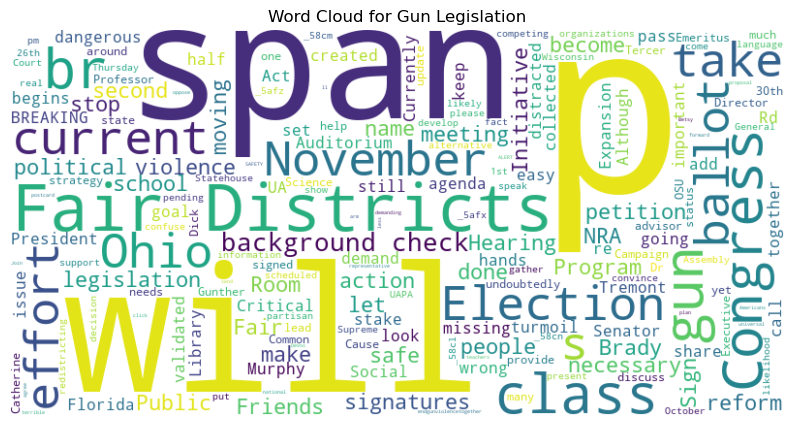

In [29]:
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'areen-prehandcode.csv'
data = pd.read_csv(file_path)

# Filter the text data to include only messages containing gun-related words
pattern = '|'.join([re.escape(word) for word in gun_related_words])
gun_legislation_messages = data[data['message'].str.contains(pattern, case=False, na=False)]['message']

# Concatenate the filtered messages into a single string
text = ' '.join(gun_legislation_messages)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Gun Legislation')
plt.show()

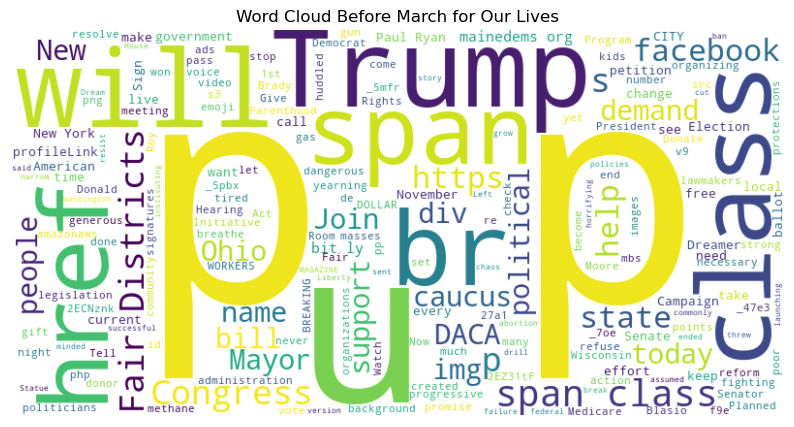

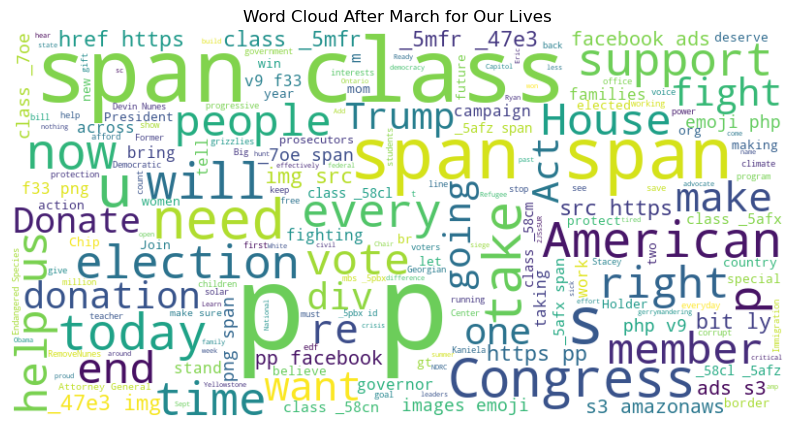

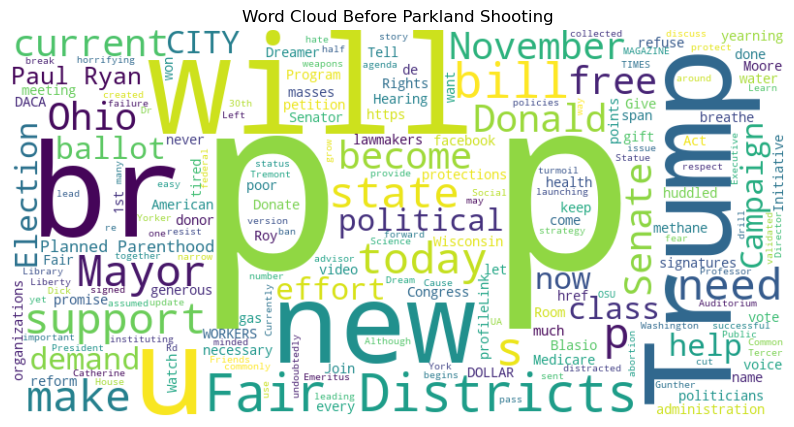

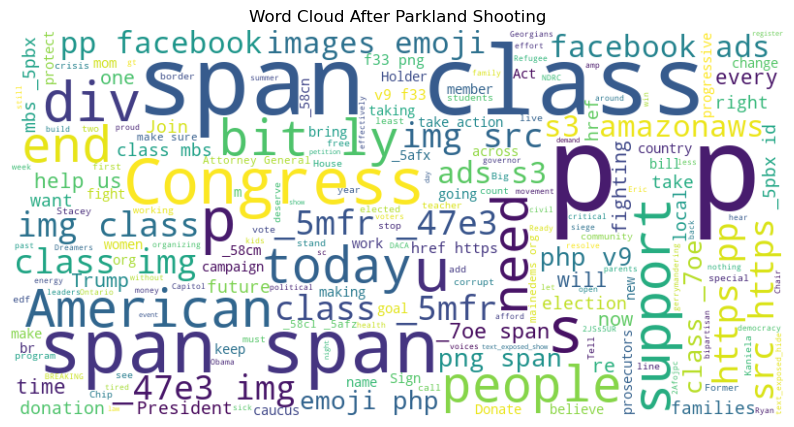

In [30]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Concatenate the filtered messages into a single string and generate word clouds
# Word cloud for messages before March for Our Lives
text_before_march = ' '.join(before_march['message'])
generate_wordcloud(text_before_march, 'Word Cloud Before March for Our Lives')

# Word cloud for messages after March for Our Lives
text_after_march = ' '.join(after_march['message'])
generate_wordcloud(text_after_march, 'Word Cloud After March for Our Lives')

# Word cloud for messages before Parkland shooting
text_before_parkland = ' '.join(before_parkland['message'])
generate_wordcloud(text_before_parkland, 'Word Cloud Before Parkland Shooting')

# Word cloud for messages after Parkland shooting
text_after_parkland = ' '.join(after_parkland['message'])
generate_wordcloud(text_after_parkland, 'Word Cloud After Parkland Shooting')

Number of filtered samples for March for Our Lives: 2


c:\Users\Areen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


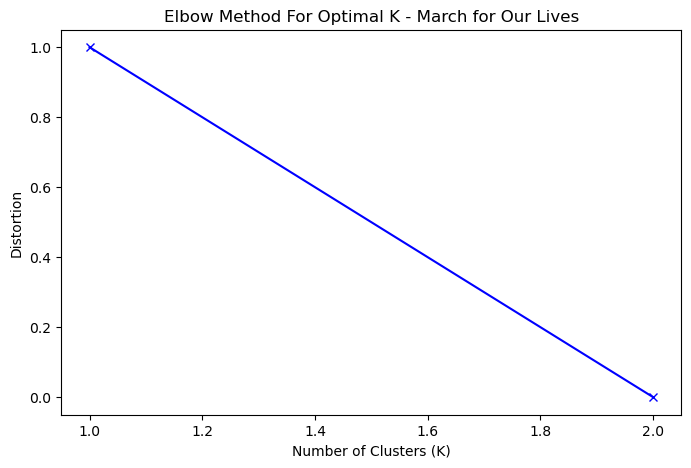

C:\Users\Areen\AppData\Local\Temp\ipykernel_3996\4214505757.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster'] = kmeans.labels_


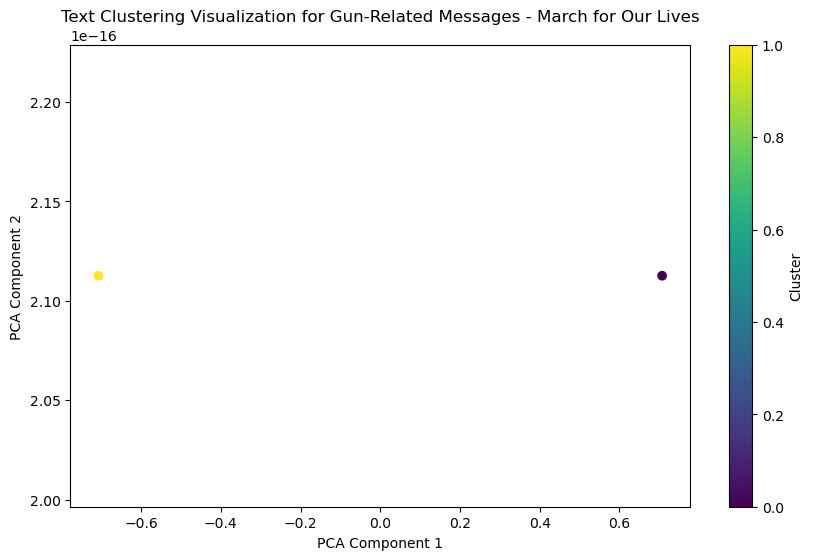

Top terms per cluster - March for Our Lives:
Cluster 0:
congress
background
brady
check
wrong
legislation
50
act
add
breaking

Cluster 1:
going
share
election
stake
seconds
let
look
nra
florida
wrong

Number of filtered samples for Parkland Shooting: 1


ValueError: Not enough samples for clustering for Parkland Shooting. Please ensure the dataset has enough data points.

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the dataset
data = pd.read_csv('areen-prehandcode.csv')

# Convert 'created_at' to datetime if it's not already
data['created_at'] = pd.to_datetime(data['created_at'], utc=True, errors='coerce')

# Define the date ranges for March for Our Lives and Parkland shooting
march_for_our_lives_date = pd.to_datetime('2018-03-24', utc=True)
parkland_shooting_date = pd.to_datetime('2018-02-14', utc=True)

# Define 6 months timedelta
six_months = pd.Timedelta(days=6*30)

# Function to check if any word from the list is present in the text
def contains_word(text, word_list):
    if pd.isnull(text):  # Check if the text is NaN
        return False
    for word in word_list:
        if re.search(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE):
            return True
    return False

# Replace 'text' with the actual column name that contains the text data
text_column = 'message'  # Change this to the correct column name

# Function to perform clustering and visualization
def perform_clustering_and_visualization(filtered_data, event_name):
    # Print the number of filtered samples
    num_samples = len(filtered_data)
    print(f"Number of filtered samples for {event_name}: {num_samples}")

    # Ensure there are enough samples for clustering
    if num_samples < 2:
        raise ValueError(f"Not enough samples for clustering for {event_name}. Please ensure the dataset has enough data points.")

    # Create TF-IDF vectors
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data[text_column])

    # Perform dimensionality reduction for visualization
    pca = PCA(n_components=2)
    tfidf_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

    # Determine the optimal number of clusters (K) using the elbow method
    distortions = []
    K = range(1, min(11, num_samples + 1))  # Ensure K is not more than the number of samples
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_matrix)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.title(f'Elbow Method For Optimal K - {event_name}')
    plt.show()

    # Choose the optimal number of clusters based on the elbow curve (e.g., K=3, K=4)
    # Perform K-means clustering
    num_clusters = min(3, num_samples)  # Change this value based on the elbow curve analysis and number of samples
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)

    # Add cluster labels to the DataFrame
    filtered_data['cluster'] = kmeans.labels_

    # Visualize clusters in 2D space
    plt.figure(figsize=(10, 6))
    plt.scatter(tfidf_matrix_pca[:, 0], tfidf_matrix_pca[:, 1], c=filtered_data['cluster'], cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Text Clustering Visualization for Gun-Related Messages - {event_name}')
    plt.colorbar(label='Cluster')
    plt.show()

    # Print the top terms per cluster
    print(f"Top terms per cluster - {event_name}:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(num_clusters):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]}")
        print()

# Filter messages related to March for Our Lives
before_march = data[(data['created_at'] > (march_for_our_lives_date - six_months)) & (data['created_at'] <= march_for_our_lives_date)]
after_march = data[(data['created_at'] > march_for_our_lives_date) & (data['created_at'] <= (march_for_our_lives_date + six_months))]
march_for_lives_data = pd.concat([before_march, after_march])
filtered_march_for_lives = march_for_lives_data[march_for_lives_data[text_column].apply(lambda x: contains_word(x, gun_related_words))]

# Perform clustering and visualization for March for Our Lives
perform_clustering_and_visualization(filtered_march_for_lives, "March for Our Lives")

# Filter messages related to Parkland shooting
before_parkland = data[(data['created_at'] > (parkland_shooting_date - six_months)) & (data['created_at'] <= parkland_shooting_date)]
after_parkland = data[(data['created_at'] > parkland_shooting_date) & (data['created_at'] <= (parkland_shooting_date + six_months))]
parkland_shooting_data = pd.concat([before_parkland, after_parkland])
filtered_parkland_shooting = parkland_shooting_data[parkland_shooting_data[text_column].apply(lambda x: contains_word(x, gun_related_words))]

# Perform clustering and visualization for Parkland shooting
perform_clustering_and_visualization(filtered_parkland_shooting, "Parkland Shooting")